### Session Creation

In [3]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col


connection_parameters = {
    "account": "<your snowflake account identifier>",
    "user": "<your snowflake username>",
    "password": "<your snowflake password>",
    "role": "<your snowflake role>",
    "warehouse": "<your snowflake warehouse>",  # optional
    "database": "<your snowflake database>",  # optional
    "schema": "<your snowflake schema>" # optional
  }

session = Session.builder.configs(connection_parameters).create()

In [8]:
FEATURE_LIST = [ "HOLIDAY", "WORKINGDAY", "WEEKDAY", "HOUR", "HUMIDITY", "MONTH", "TEMP", "YEAR", "ATEMP", "WINDSPEED", "SEASON", "WEATHER"]
LABEL_COLUMNS = ['COUNT']
OUTPUT_COLUMNS = ['PREDICTED_COUNT']

df = session.table("MODEL_DATA")
df = df.drop("DATETIME","DATE")
df.show(2)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"       |"CASUAL"  |"REGISTERED"  |"COUNT"  |"HOUR"  |"MONTH"  |"WEEKDAY"  |"YEAR"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |12.7993954069447  |3         |13            |16       |0       |1        |6          |2011    |
|1         |0          |0             |1          |9.02    |13.635   |80          |12.7993954069447  |8         |32            |40       |1       |1        |6          |2011    |
---------------------------------------------------------------------------------------------------------

### Preparing the Model -  XGBoost

* Code block delineates building XGboost model by optimizing two parameters through Gridsearch
* Contains code snippets to find optimal model parameters - max_depth & min_child_weight

In [ ]:
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.xgboost import XGBRegressor


param_grid = {
        "max_depth":[3, 4, 5, 6, 7, 8],
        "min_child_weight":[1, 2, 3, 4],
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    n_jobs = -1,
    scoring="neg_root_mean_squared_error",
    input_cols=FEATURE_LIST,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

In [ ]:
grid_search.fit(train_df)

[01:52:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



/Users/paranthamansrinivasan/Environment/piperr/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
grid_search.to_sklearn().best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

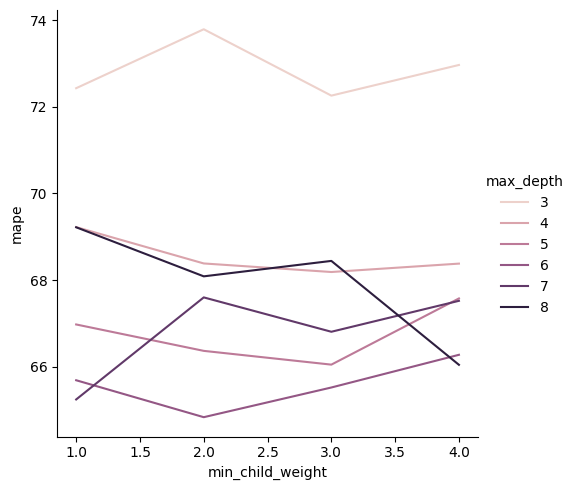

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

gs_results = grid_search.to_sklearn().cv_results_
max_depth_val = []
min_child_weight_val = []
for param_dict in gs_results["params"]:
    max_depth_val.append(param_dict["max_depth"])
    min_child_weight_val.append(param_dict["min_child_weight"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "max_depth":max_depth_val,
    "min_child_weight":min_child_weight_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="min_child_weight", y="mape", hue="max_depth", kind="line")

plt.show()

In [ ]:
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

result = grid_search.predict(test_df)
mape = mean_absolute_percentage_error(df=result,
                                        y_true_col_names="COUNT",
                                        y_pred_col_names="PREDICTED_COUNT")

result.select("COUNT", "PREDICTED_COUNT").show()
print(f"Mean absolute percentage error: {mape}")

---------------------------------
|"COUNT"  |"PREDICTED_COUNT"    |
---------------------------------
|1        |-3.388032913208008   |
|3        |-17.230443954467773  |
|36       |81.77940368652344    |
|94       |139.5572052001953    |
|106      |119.69203186035156   |
|93       |45.62565231323242    |
|37       |2.392047166824341    |
|28       |12.154733657836914   |
|39       |31.08808135986328    |
|17       |13.183290481567385   |
---------------------------------

Mean absolute percentage error: 0.4065023816216072


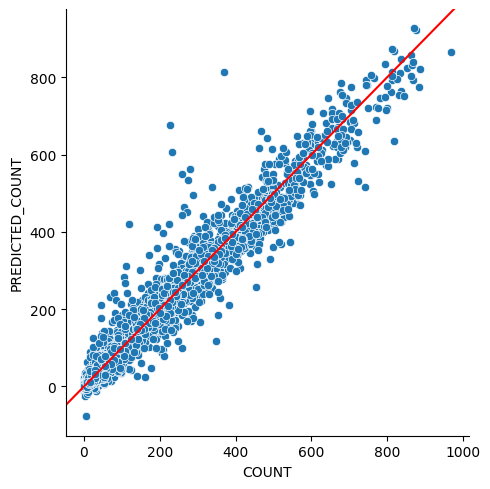

In [ ]:
g = sns.relplot(data=result["COUNT", "PREDICTED_COUNT"].to_pandas().astype("float64"), x="COUNT", y="PREDICTED_COUNT", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### Registering The Model


In [ ]:
from snowflake.ml.registry import model_registry
registry = model_registry.ModelRegistry(session=session, database_name="SNOWPARK", schema_name="TUTORIAL", create_if_not_exists=True)

optimal_model = grid_search.to_sklearn().best_estimator_
optimal_max_depth = grid_search.to_sklearn().best_estimator_.max_depth
optimal_min_child_weight = grid_search.to_sklearn().best_estimator_.min_child_weight

optimal_mape = gs_results_df.loc[(gs_results_df['max_depth']==optimal_max_depth) &
                                 (gs_results_df['min_child_weight']==optimal_min_child_weight), 'mape'].values[0]

In [ ]:
model_name = "bike_model_xg_boost"
model_version = 1

registry.log_model(
    model_name=model_name,
    model_version=model_version,
    model=optimal_model,
    sample_input_data=X,
    options={"embed_local_ml_library": True, "relax": True})

registry.set_metric(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err", metric_value=optimal_mape)

/Users/paranthamansrinivasan/Environment/piperr/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:55: UserWarning: The sample input has 100 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If that happens, consider specifying signature manually.
  warnings.warn(


In [ ]:
#LIST MODELS IN THE REGISTRY

registry.list_models().to_pandas()

,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.10.12""\n}","""ACCOUNTADMIN""",2023-12-01 12:15:13.813000-08:00,50c21c92908611ee966a82be22e42801,None,bike_model_gradient_boost,None,None,sklearn,sfc://SNOWPARK.TUTORIAL.SNOWML_MODEL_50C21C929...,1,None,None,"{\n ""mean_abs_pct_err"": 68.89848373507952\n}",None,2023-12-01 12:15:15.062000-08:00
1,None,"{\n ""python"": ""3.10.12""\n}","""ACCOUNTADMIN""",2023-12-01 12:30:39.933000-08:00,79bdc69e908811ee966a82be22e42801,None,bike_model_xg_boost,None,None,xgboost,sfc://SNOWPARK.TUTORIAL.SNOWML_MODEL_79BDC69E9...,1,None,None,"{\n ""mean_abs_pct_err"": 64.83345565795898\n}",None,2023-12-01 12:30:41.635000-08:00


### Model Registry Method
* Code snippets covers all vital model registry methods. Methods include as following
* Set, get & remove tags / Set model description
* Ways to access registry history & finding evaluation metric
* Loading model from registry

In [ ]:
#set tag for your model

registry.set_tag(model_name=model_name, model_version=model_version, tag_name="usage", tag_value="experiment")
registry.list_models().to_pandas()[["NAME", "TAGS"]]

,NAME,TAGS
0,bike_model_gradient_boost,None
1,bike_model_xg_boost,"{\n ""usage"": ""experiment""\n}"


In [ ]:
#removing tag

registry.remove_tag(model_name=model_name, model_version=model_version, tag_name="usage")
registry.list_models().to_pandas()[["NAME", "TAGS"]]

,NAME,TAGS
0,bike_model_gradient_boost,None
1,bike_model_xg_boost,{}


In [ ]:
#get tag value
registry.set_tag(model_name=model_name, model_version=model_version, tag_name="usage", tag_value="experiment")
print(registry.get_tag_value(model_name=model_name, model_version=model_version, tag_name="usage"))

#get all tags
print(registry.get_tags(model_name=model_name, model_version=model_version))

experiment
{'usage': 'experiment'}


In [ ]:
#MODEL DESCRIPTION

registry.set_model_description(model_name=model_name, model_version=model_version, description="this is a test model")
print(registry.get_model_description(model_name=model_name, model_version=model_version))

In [ ]:

#REGISTRY HISTORY
registry.get_history().to_pandas()

,EVENT_TIMESTAMP,EVENT_ID,MODEL_ID,ROLE,OPERATION,ATTRIBUTE_NAME,VALUE[ATTRIBUTE_NAME]
0,2023-12-01 12:15:15.062000-08:00,56a22026908611ee966a82be22e42801,50c21c92908611ee966a82be22e42801,"""ACCOUNTADMIN""",SET,REGISTRATION,"{\n ""CREATION_ENVIRONMENT_SPEC"": {\n ""pyth..."
1,2023-12-01 12:15:56.154000-08:00,6f2016a8908611ee966a82be22e42801,50c21c92908611ee966a82be22e42801,"""ACCOUNTADMIN""",SET,METRICS,"{\n ""mean_abs_pct_err"": 68.89848373507952\n}"
2,2023-12-01 12:30:41.635000-08:00,7ef0d1ba908811ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,REGISTRATION,"{\n ""CREATION_ENVIRONMENT_SPEC"": {\n ""pyth..."
3,2023-12-01 12:30:43.894000-08:00,804a0310908811ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,METRICS,"{\n ""mean_abs_pct_err"": 64.83345565795898\n}"
4,2023-12-01 12:46:05.847000-08:00,a5d037f6908a11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
5,2023-12-01 12:46:39.728000-08:00,ba0225e0908a11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
6,2023-12-01 12:47:12.537000-08:00,cd906536908a11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
7,2023-12-01 12:47:51.897000-08:00,e5069492908a11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,{}
8,2023-12-01 12:48:57.841000-08:00,0c54a7fa908b11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
9,2023-12-01 12:49:35.160000-08:00,22911918908b11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"


In [ ]:

#MODEL HISTORY
registry.get_model_history(model_name=model_name, model_version=model_version).to_pandas()

,EVENT_TIMESTAMP,EVENT_ID,MODEL_ID,ROLE,OPERATION,ATTRIBUTE_NAME,VALUE[ATTRIBUTE_NAME]
0,2023-12-01 12:30:41.635000-08:00,7ef0d1ba908811ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,REGISTRATION,"{\n ""CREATION_ENVIRONMENT_SPEC"": {\n ""pyth..."
1,2023-12-01 12:30:43.894000-08:00,804a0310908811ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,METRICS,"{\n ""mean_abs_pct_err"": 64.83345565795898\n}"
2,2023-12-01 12:46:05.847000-08:00,a5d037f6908a11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
3,2023-12-01 12:46:39.728000-08:00,ba0225e0908a11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
4,2023-12-01 12:47:12.537000-08:00,cd906536908a11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
5,2023-12-01 12:47:51.897000-08:00,e5069492908a11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,{}
6,2023-12-01 12:48:57.841000-08:00,0c54a7fa908b11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
7,2023-12-01 12:49:35.160000-08:00,22911918908b11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
8,2023-12-01 12:50:15.189000-08:00,3a6fc2d2908b11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
9,2023-12-01 12:50:58.378000-08:00,542db724908b11ee966a82be22e42801,79bdc69e908811ee966a82be22e42801,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"


In [ ]:
#CHECK EVALUATION METRIC OF A MODEL

registry.get_metric_value(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err")

64.83345565795898

In [ ]:
#GET ALL METRICS STORED FOR A MODEL
registry.get_metrics(model_name=model_name, model_version=model_version)

{'mean_abs_pct_err': 64.83345565795898}

In [ ]:
#load model from registry
xg_boost_model = registry.load_model(model_name=model_name, model_version=model_version)
xg_boost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'int', 'int', 'int', 'float',
                            'int', 'float', 'float', 'int', 'int'],
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Deploying Model From Registry 

* Code snippet delineates steps involved in deployed model registered in model registry
* Also explains steps to predict using deployed models

In [ ]:
#deploying a model from model registry
model_deployment_name = model_name + f"{model_version}" + "_UDF"

registry.deploy(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name,
                target_method="predict",
                permanent=True,
                options={"relax_version": True})

{'name': 'SNOWPARK.TUTORIAL.bike_model_xg_boost1_UDF',
 'platform': <TargetPlatform.WAREHOUSE: 'warehouse'>,
 'target_method': 'predict',
 'signature': ModelSignature(
                     inputs=[
                         FeatureSpec(dtype=DataType.INT8, name='HOLIDAY'),
 		FeatureSpec(dtype=DataType.INT8, name='WORKINGDAY'),
 		FeatureSpec(dtype=DataType.INT8, name='WEEKDAY'),
 		FeatureSpec(dtype=DataType.INT8, name='HOUR'),
 		FeatureSpec(dtype=DataType.INT8, name='HUMIDITY'),
 		FeatureSpec(dtype=DataType.INT8, name='MONTH'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='TEMP'),
 		FeatureSpec(dtype=DataType.INT16, name='YEAR'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='ATEMP'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='WINDSPEED'),
 		FeatureSpec(dtype=DataType.INT8, name='SEASON'),
 		FeatureSpec(dtype=DataType.INT8, name='WEATHER')
                     ],
                     outputs=[
                         FeatureSpec(dtype=DataType.FLOAT, name='output_feature_0')
       

In [ ]:
#list all deployments for a model
registry.list_deployments(model_name, model_version).to_pandas()

,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE
0,bike_model_xg_boost,1,bike_model_xg_boost1_UDF,2023-12-01 13:17:31.194000-08:00,predict,warehouse,"{\n ""inputs"": [\n {\n ""name"": ""HOLIDA...","{\n ""permanent_udf_stage_location"": ""@SNOWPAR...",@SNOWPARK.TUTORIAL._SYSTEM_REGISTRY_DEPLOYMENT...,"""ACCOUNTADMIN"""


In [ ]:
model_ref = model_registry.ModelReference(registry=registry, model_name=model_name, model_version=model_version)
result_sdf = model_ref.predict(deployment_name=model_deployment_name, data=test_df)
result_sdf.show()

/Users/paranthamansrinivasan/Environment/piperr/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:310: RuntimeWarning: Warn in feature HOLIDAY: Nullable column HOLIDAY provided, inference might fail if there is null value.
  warnings.warn(
/Users/paranthamansrinivasan/Environment/piperr/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:310: RuntimeWarning: Warn in feature WORKINGDAY: Nullable column WORKINGDAY provided, inference might fail if there is null value.
  warnings.warn(
/Users/paranthamansrinivasan/Environment/piperr/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:310: RuntimeWarning: Warn in feature WEEKDAY: Nullable column WEEKDAY provided, inference might fail if there is null value.
  warnings.warn(
/Users/paranthamansrinivasan/Environment/piperr/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:310: RuntimeWarning: Warn in feature HOUR: Nullable column HOUR provided, inference might fail if there is n

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"       |"CASUAL"  |"REGISTERED"  |"COUNT"  |"HOUR"  |"MONTH"  |"WEEKDAY"  |"YEAR"  |"output_feature_0"   |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |75          |12.7993954069447  |0         |1             |1        |4       |1        |6          |2011    |-3.388032913208008   |
|1         |0          |0             |1          |8.2     |12.88    |86          |12.7993954069447  |1         |2             |3        |7       |1        |6          |2011    |-17.23044395446777

### Delete Model From Deployment & Registry

In [ ]:
#delete deployment
registry.delete_deployment(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name)
registry.list_deployments(model_name, model_version).to_pandas()

,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE


In [ ]:
#delete model from registry
registry.delete_model(model_name=model_name,
                model_version=model_version)
registry.list_models().to_pandas()

,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.10.12""\n}","""ACCOUNTADMIN""",2023-12-01 12:15:13.813000-08:00,50c21c92908611ee966a82be22e42801,None,bike_model_gradient_boost,None,None,sklearn,sfc://SNOWPARK.TUTORIAL.SNOWML_MODEL_50C21C929...,1,None,None,"{\n ""mean_abs_pct_err"": 68.89848373507952\n}",None,2023-12-01 12:15:15.062000-08:00
